In [1]:
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import numpy as np

raw_edu = pd.read_csv('Education/education_data_2019.csv')
raw_inco = pd.read_csv('Income/income_data_2019.csv')
raw_popul_20 = pd.read_csv('Population/population_2020.csv', encoding='iso-8859-1')
raw_covid_20 = pd.read_csv('COVID-19/USA_COVID-19_2020.csv', encoding='iso-8859-1')
raw_covid_21 = pd.read_csv('COVID-19/USA_COVID-19_2021.csv', encoding='iso-8859-1')

In [2]:
df_dict = {}
states = ['California', 'Florida', 'New York']
sts = ['CA', 'FL', 'NY']

for state, st in zip(states, sts):
    
    popul_df = raw_popul_20[raw_popul_20['State'] == state]
    st_popul = popul_df['Estimate'].sum()
    
    edu_df = raw_edu[raw_edu['State'] == state]
    inco_df = raw_inco[raw_inco['State'] == state]
    covid_20df = raw_covid_20[raw_covid_20['State'] == state]
    covid_20_df = covid_20df[covid_20df['date'] == '12/31/2020'].reset_index(drop=True)
    covid_21df = raw_covid_21[raw_covid_21['State'] == state]
    covid_21_df = covid_21df[covid_21df['date'] == '2021-12-31'].reset_index(drop=True)
    covid_20_df['County'] = covid_21_df['County']

    df_dict[st] = [popul_df, edu_df, inco_df, covid_20_df, covid_21_df]
    len_dfs = [len(popul_df), len(edu_df), len(inco_df), len(covid_20_df), len(covid_21_df)]
    len_min = len_dfs.index(min(len_dfs))
    cnts_filt = (covid_21_df['County'].isin(df_dict[st][len_min]['County'].tolist()))
    counties = covid_21_df[cnts_filt]['County'].tolist()

    for i in range(len(len_dfs)):
        cnts_filt = (df_dict[st][i]['County'].isin(counties))
        df_dict[st][i] = df_dict[st][i][cnts_filt].reset_index(drop=True)
        
    st_df = pd.DataFrame()
    st_df['County'] = counties
    popul = df_dict[st][0]['Estimate']
    ratio = df_dict[st][1]['Ratio']
    household = df_dict[st][2]['Households_total']
    st_df['Population'] = popul
    st_df['Ratio'] = ratio
    st_df['Household'] = household
    st_df['Interaction'] = (ratio/ratio.max())*(household/household.max())
    st_df['Death_rt_2020'] = 1E5*df_dict[st][3]['deaths']/popul
    st_df['Death_rt_2021'] = 1E5*df_dict[st][4]['deaths']/popul
    st_df['State'] = state
    sts_column = st_df.pop('State')
    st_df.insert(0, 'State', sts_column)
    
    st_covid_20 = pd.DataFrame()
    st_covid_20['date'] = pd.to_datetime(covid_20df.date)
    st_covid_20['deaths'] = covid_20df['deaths']
    st_covid_20 = st_covid_20.groupby(['date']).sum().reset_index()
    st_covid_20['death_rate'] = 1E5*st_covid_20['deaths']/st_popul
    st_covid_20['state'] = state
    st_covid_20['year'] = '2020'
    st_covid_20.insert(0, 'state', st_covid_20.pop('state'))
    st_covid_21 = pd.DataFrame()
    st_covid_21['date'] = pd.to_datetime(covid_21df.date)
    st_covid_21['deaths'] = covid_21df['deaths']
    st_covid_21 = st_covid_21.groupby(['date']).sum().reset_index()
    st_covid_21['death_rate'] = 1E5*st_covid_21['deaths']/st_popul
    st_covid_21['state'] = state
    st_covid_21['year'] = '2021'
    st_covid_21.insert(0, 'state', st_covid_21.pop('state'))
    covid_frames = [st_covid_20, st_covid_21]
    covid_time = pd.concat(covid_frames).reset_index(drop=True)
    
    df_dict[st] = [st_df, covid_time]

In [13]:
st_frames = [df_dict['CA'][0], df_dict['FL'][0], df_dict['NY'][0]]
st_merged = pd.concat(st_frames).reset_index(drop=True)
st_merged.to_csv('states_merged.csv', index=False)

cv19_st_frames = [df_dict['CA'][1], df_dict['FL'][1], df_dict['NY'][1]]
cv19_merged = pd.concat(cv19_st_frames).reset_index(drop=True)
cv19_merged.date = cv19_merged.date.apply(lambda t: t.date())
cv19_merged['day'] = (cv19_merged['date'] - cv19_merged.date[0])/np.timedelta64(1, 'D')
cv19_merged.to_csv('cv19_merged.csv', index=False)

<AxesSubplot:xlabel='Interaction', ylabel='Death_rt_2021'>

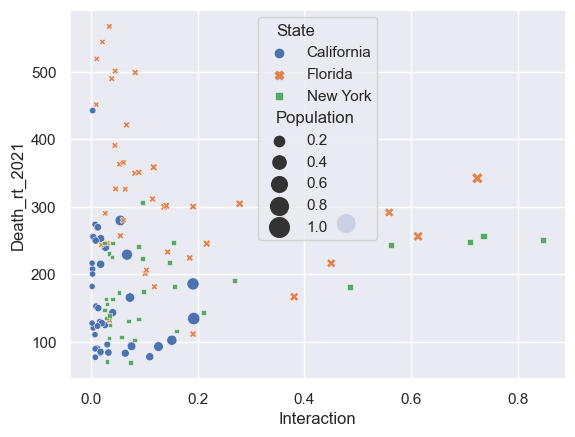

In [10]:
sns.set(style="darkgrid")

#sns.scatterplot(st_merged, x="Ratio", y="Household", hue="State", style="State")
#plt.ylim(-0.05E6, 1.2E6)

#sns.scatterplot(st_merged, x="Ratio", y="Death_rt_2021", hue="State", style="State")

sns.scatterplot(st_merged, x="Interaction", y="Death_rt_2021",
                hue="State", style="State", size="Population", sizes=(20, 200))

#sns.scatterplot(st_merged, x="Household", y="Death_rt_2021", hue="State", style="State")
#plt.xlim(-0.05E6, 1.2E6)


<AxesSubplot:xlabel='day', ylabel='death_rate'>

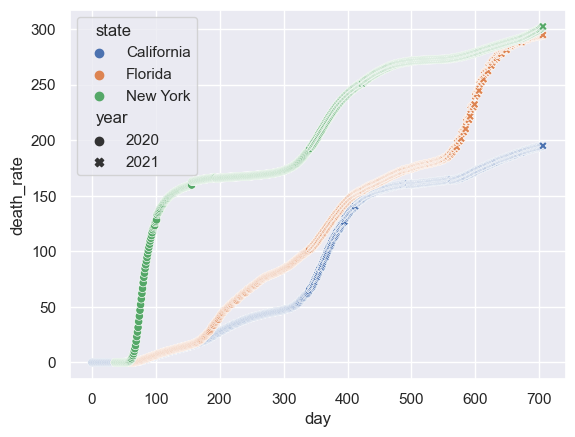

In [11]:
sns.scatterplot(cv19_merged, x="day", y="death_rate", hue="state", style="year")

In [12]:
st_merged

,State,County,Population,Ratio,Household,Interaction,Death_rt_2020,Death_rt_2021
0,California,Alameda,1661584,0.33,585632,0.126225,39.540583,92.923379
1,California,Butte,223344,0.18,77651,0.009129,42.983022,152.679275
2,California,Contra Costa,1147788,0.29,399792,0.075725,29.186575,93.484163
3,California,El Dorado,190345,0.24,74216,0.011634,11.557961,90.362237
4,California,Fresno,990204,0.13,315974,0.026829,65.239082,240.253524
...,...,...,...,...,...,...,...,...
111,New York,Tompkins,102237,0.31,40322,0.073566,13.693673,69.446482
112,New York,Ulster,178371,0.24,69376,0.097993,79.048724,174.916326
113,New York,Warren,64187,0.23,29593,0.040058,49.854332,163.584526
114,New York,Wayne,90103,0.16,36634,0.034497,39.954275,138.730120
